# Intent Classification in Question-Answering Using LSTM Architectures

Importing libraries:

In [1]:
import string
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc
from keras import optimizers
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import sklearn.metrics as metrics
from tensorflow.keras import Model
from keras.utils import to_categorical
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.metrics import AUC
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from tensorflow.keras.activations import relu, softmax
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import CategoricalCrossentropy as CC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import he_uniform, glorot_uniform
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout, Input

## Reading Data and Exploration

In [2]:
train_data = pd.read_csv('TREC Dataset/train.csv')

In [3]:
test_data = pd.read_csv('TREC Dataset/test.csv')

In [4]:
train_data

,label-coarse,label-fine,text
0,0,0,How did serfdom develop in and then leave Russ...
1,1,1,What films featured the character Popeye Doyle ?
2,0,0,How can I find a list of celebrities ' real na...
3,1,2,What fowl grabs the spotlight after the Chines...
4,2,3,What is the full form of .com ?
...,...,...,...
5447,1,14,What 's the shape of a camel 's spine ?
5448,1,46,What type of currency is used in China ?
5449,4,41,What is the temperature today ?
5450,4,41,What is the temperature for cooking ?


Number of nique label-coarse and label-fines. And also number of label-fines for each label-coarse: 

In [5]:
print('label-coarse: ', train_data['label-coarse'].nunique())
print('label-fine: ', train_data['label-fine'].nunique())
print('label-fine grouped by label-coarse: ', train_data.groupby('label-coarse')['label-fine'].nunique())

label-coarse:  6
label-fine:  47
label-fine grouped by label-coarse:  label-coarse
0     4
1    22
2     2
3     4
4    13
5     5
Name: label-fine, dtype: int64


Number of samples for each label-coarse:

In [6]:
grouped_by = train_data.groupby('label-coarse')['label-fine'].sum()
df_r = grouped_by.transpose().reset_index(drop=True)
df_r

0     7954
1    20618
2      754
3     5507
4    15540
5    13225
Name: label-fine, dtype: int64

Number of label-fines per label-coarse plot:

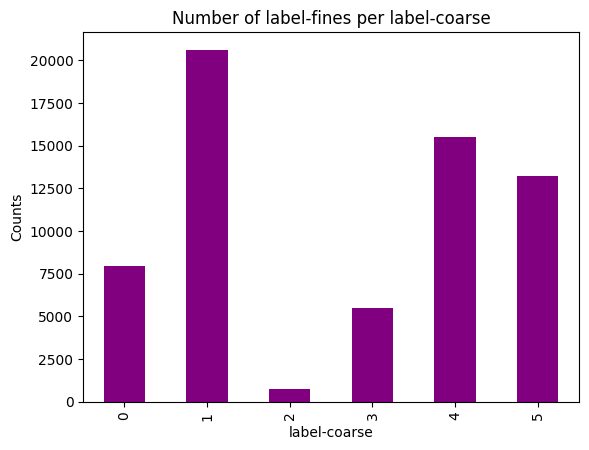

In [7]:
df_r.plot.bar(color='purple')
plt.title("Number of label-fines per label-coarse")
plt.xlabel("label-coarse")
plt.ylabel("Counts")
plt.show()

Number of words in each text:

In [8]:
train_data['words-count'] = train_data['text'].apply(lambda x: len(x.split()))
train_data.head()

,label-coarse,label-fine,text,words-count
0,0,0,How did serfdom develop in and then leave Russ...,10
1,1,1,What films featured the character Popeye Doyle ?,8
2,0,0,How can I find a list of celebrities ' real na...,12
3,1,2,What fowl grabs the spotlight after the Chines...,13
4,2,3,What is the full form of .com ?,8


Maximum number of words:

In [9]:
print('Maximum words count in text : ', max(train_data['words-count']))

Maximum words count in text :  37


Ploting number of words in each sample:

Text(0, 0.5, 'Word Counts')

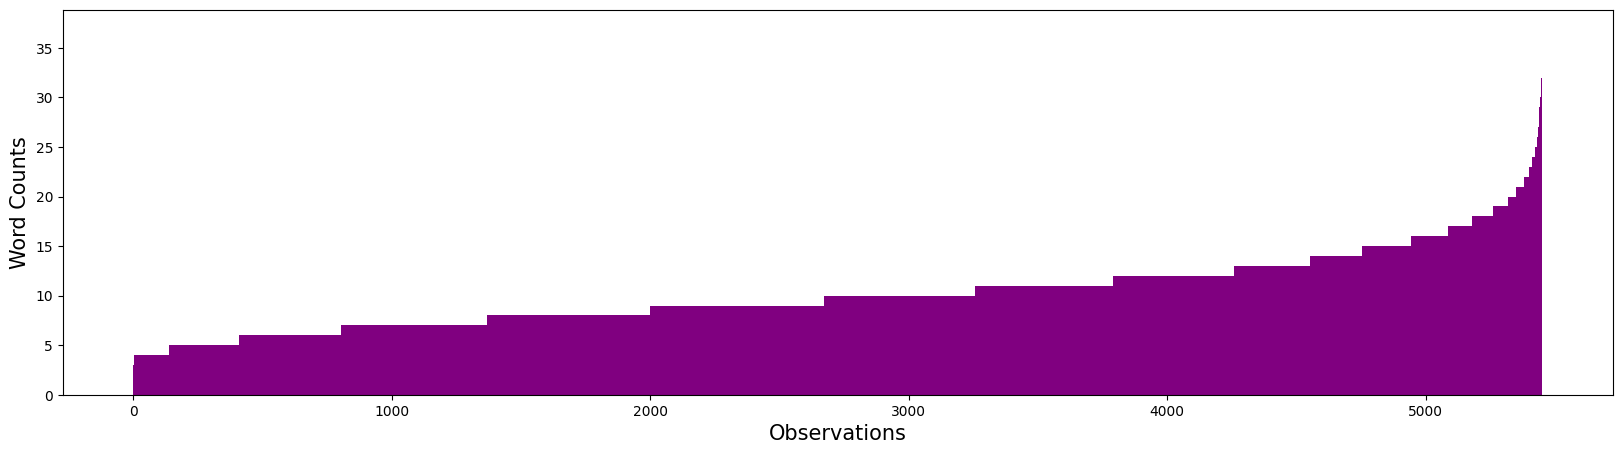

In [10]:
plt.figure(figsize=(20,5))
plt.bar(np.arange(len(train_data['words-count'])), 
        sorted(train_data['words-count'].values), width=1, color='purple')
plt.xlabel("Observations", fontsize=15)
plt.ylabel("Word Counts", fontsize=15)

Mean and median of number of words:

In [11]:
print("Words count mean: ", train_data['words-count'].mean())
print("Words count median: ", train_data['words-count'].median())

Words count mean:  10.204695524578137
Words count median:  10.0


Most common words:

In [12]:
most_common = Counter(" ".join(train_data['text']).split()).most_common(20)
most_common

[('?', 5350),
 ('the', 3611),
 ('What', 3246),
 ('is', 1679),
 ('of', 1546),
 ('in', 1133),
 ('a', 1010),
 ('How', 764),
 ("'s", 720),
 ('was', 652),
 ('to', 604),
 (',', 571),
 ('Who', 561),
 ('are', 453),
 ('for', 450),
 ('and', 425),
 ("''", 401),
 ('``', 399),
 ('does', 390),
 ('did', 388)]

In [13]:
train_data

,label-coarse,label-fine,text,words-count
0,0,0,How did serfdom develop in and then leave Russ...,10
1,1,1,What films featured the character Popeye Doyle ?,8
2,0,0,How can I find a list of celebrities ' real na...,12
3,1,2,What fowl grabs the spotlight after the Chines...,13
4,2,3,What is the full form of .com ?,8
...,...,...,...,...
5447,1,14,What 's the shape of a camel 's spine ?,10
5448,1,46,What type of currency is used in China ?,9
5449,4,41,What is the temperature today ?,6
5450,4,41,What is the temperature for cooking ?,7


## Preprocessing

### Lable One Hot Encoding

One Hot Encoding label-coarse:

In [14]:
label_encoder= OneHotEncoder().fit(np.array(train_data['label-coarse']).reshape(-1,1))

label_tr_encoded= label_encoder.transform(np.array(train_data['label-coarse']).reshape(-1,1)).toarray()
label_ts_encoded= label_encoder.transform(np.array(test_data['label-coarse']).reshape(-1,1)).toarray()

In [15]:
label_tr_encoded

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [16]:
y_train_main = np.array([train_data.iloc[i]['label-coarse'] for i in range(len(train_data))])
y_test_main = np.array([test_data.iloc[i]['label-coarse'] for i in range(len(test_data))])

y_train_main = to_categorical(y_train_main.squeeze())
y_test_main = to_categorical(y_test_main.squeeze())

### Normalization and Tokenization

In [17]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
print(type(string.punctuation))
print(string.punctuation)

<class 'str'>
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Making all characters lowercase and removing special and stop words:

In [19]:
def preprocess_text(text):
    text = text.lower()
    text = text.replace(r'[^a-zA-Z\s]', '')
    puncts_to_delete = string.punctuation.replace('?', '')
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in puncts_to_delete]

    # stop_words = set(stopwords.words('english'))
    # tokens = [token for token in tokens if token not in stop_words]
    
    # lemmatizer = WordNetLemmatizer()
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

Applying preprocessing:

In [20]:
train_data['preprocessed_text'] = train_data['text'].apply(preprocess_text)
test_data['preprocessed_text'] = test_data['text'].apply(preprocess_text)

Tokenization and sequence padding:

In [21]:
vocab_size = 9000

tokenizer = Tokenizer(num_words = vocab_size)

tokenizer.fit_on_texts(train_data['preprocessed_text'])
train_sequences = tokenizer.texts_to_sequences(train_data['preprocessed_text'])

tokenizer.fit_on_texts(test_data['preprocessed_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['preprocessed_text'])

Finding text max length in each train and test data:

In [22]:
max_len_train = max([len(x) for x in train_sequences])
max_len_test = max([len(x) for x in test_sequences])

In [23]:
print(max_len_train)
print(max_len_test)

33
17


Sequence padding:

In [24]:
train_padded = pad_sequences(train_sequences, maxlen= max_len_train, padding= "post")
test_padded = pad_sequences(test_sequences, maxlen= max_len_train, padding= "post")

In [25]:
train_padded.shape

(5452, 33)

In [26]:
test_padded.shape

(500, 33)

In [27]:
train_padded

array([[   7,   16, 3501, ...,    0,    0,    0],
       [   2,  800,  601, ...,    0,    0,    0],
       [   7,   25,   22, ...,    0,    0,    0],
       ...,
       [   2,    3,    1, ...,    0,    0,    0],
       [   2,    3,    1, ...,    0,    0,    0],
       [   2, 3500,    3, ...,    0,    0,    0]])

In [28]:
train_padded[286]

array([  11,    9,    1,  498,    4,    1,   95,   73,  166, 3748,   52,
          1, 2345,    8, 1030, 3749,    6, 1318,  199,    1, 3750,    4,
        166, 2346,    0,    0,    0,    0,    0,    0,    0,    0,    0])

### Embedding Matrix

Loading GloVe embeddings:

In [29]:
embeddings_index = {}
with open('glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

Making embedding matrix:

In [30]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Model 1

Making Model1 class:

In [31]:
class Model1(object):
        
    def build(self, input_dim, num_classes, embedding_dim, embedding_matrix, 
              max_len_train, hidden_state, activation_func, learn_rate):

        self.classes = ['0', '1' , '2' , '3' , '4' , '5']
        self.model = Sequential()
        Embedding_layer = Embedding(input_dim = input_dim, output_dim = embedding_dim, 
                                    weights = [embedding_matrix], input_length = max_len_train, trainable = False)
                  
        self.model.add(Embedding_layer)
        self.model.add(LSTM(units = hidden_state))
        self.model.add(Dense(num_classes, activation = activation_func))
        
        optimizer = optimizers.Adam(learning_rate = learn_rate)
        self.model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        self.model.summary()
        self.model_history = None
        self.pred_labels = None
                  
    def train(self, x, y, validation_split, epochs, batch_size):
        print("Fitting")
        self.model_history = self.model.fit(x, y, validation_split = validation_split, epochs = epochs, batch_size = batch_size)
        
    def predict(self, x):
        pred = self.model.predict(x)
        self.pred_labels = np.array([np.argmax(y) for y in pred])
        
    def plot_result(self, accuracy_or_loss):
        plt.plot(self.model_history.history[accuracy_or_loss], label = accuracy_or_loss + '(training data)')
        plt.plot(self.model_history.history['val_' + accuracy_or_loss], label = accuracy_or_loss + '(validation data)')
        plt.title(accuracy_or_loss)
        plt.ylabel(accuracy_or_loss + ' value')
        plt.xlabel('Number of Epoch')
        if accuracy_or_loss == 'accuracy':
            plt.legend(loc = "lower right")
        else: 
            plt.legend(loc = "upper right")
        plt.grid()
        plt.show()
        
    def report(self, labels):
        test_labels = np.array([np.argmax(y) for y in labels])
        print(classification_report(test_labels, self.pred_labels, target_names = self.classes))

    def show_cm(self, labels):
        test_labels = np.array([np.argmax(y) for y in labels])
        confusion_matrix = metrics.confusion_matrix(test_labels, self.pred_labels)
        display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = self.classes)
        
        display_cm.plot()
        plt.show()

### Hidden State = 25

Building model with hidden_state = 25: 

In [32]:
num_classes = 6
hidden_state = 25

model1_25 = Model1()
model1_25.build(input_dim = vocab_size, 
            num_classes = num_classes, 
            embedding_dim = embedding_dim,
            embedding_matrix = embedding_matrix, 
            max_len_train = max_len_train, 
            hidden_state = hidden_state, 
            activation_func = 'softmax', 
            learn_rate = 0.0000001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 300)           2700000   
                                                                 
 lstm (LSTM)                 (None, 25)                32600     
                                                                 
 dense (Dense)               (None, 6)                 156       
                                                                 
Total params: 2,732,756
Trainable params: 32,756
Non-trainable params: 2,700,000
_________________________________________________________________


In [33]:
model1_25.train(train_padded, y_train_main, 0.2, 100, 128)

Fitting
Epoch 1/100
35/35 [==============================] - 4s 45ms/step - loss: 1.7539 - accuracy: 0.2162 - val_loss: 1.6896 - val_accuracy: 0.2136
Epoch 2/100
35/35 [==============================] - 1s 26ms/step - loss: 1.6549 - accuracy: 0.2497 - val_loss: 1.6253 - val_accuracy: 0.2649
Epoch 3/100
35/35 [==============================] - 1s 26ms/step - loss: 1.5377 - accuracy: 0.3600 - val_loss: 1.4546 - val_accuracy: 0.4005
Epoch 4/100
35/35 [==============================] - 1s 27ms/step - loss: 1.3381 - accuracy: 0.4731 - val_loss: 1.2615 - val_accuracy: 0.4840
Epoch 5/100
35/35 [==============================] - 1s 27ms/step - loss: 1.1773 - accuracy: 0.5377 - val_loss: 1.1930 - val_accuracy: 0.5151
Epoch 6/100
35/35 [==============================] - 1s 25ms/step - loss: 1.1276 - accuracy: 0.5604 - val_loss: 1.1827 - val_accuracy: 0.5417
Epoch 7/100
35/35 [==============================] - 1s 25ms/step - loss: 1.0151 - accuracy: 0.6315 - val_loss: 1.0905 - val_accuracy: 0.595

Ploting accuracy of model on training data:

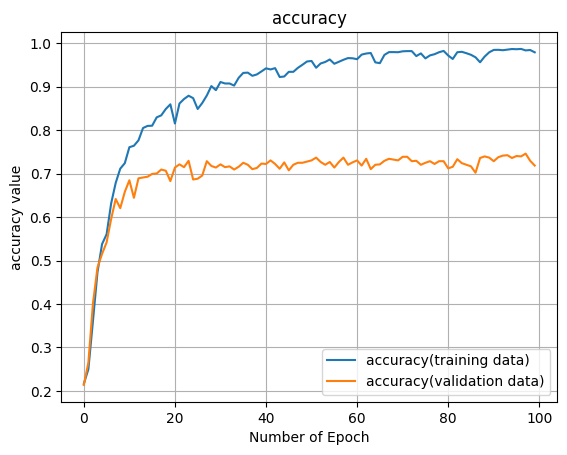

In [34]:
model1_25.plot_result('accuracy')

Ploting loss of model on training data:

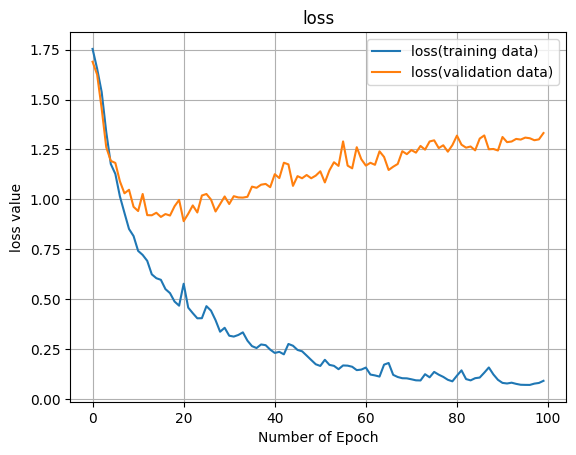

In [35]:
model1_25.plot_result('loss')

Predicting:

In [36]:
model1_25.predict(test_padded)

16/16 [==============================] - 0s 6ms/step


Reporting results:

In [37]:
model1_25.report(y_test_main)

              precision    recall  f1-score   support

           0       0.51      0.78      0.61       138
           1       0.39      0.47      0.43        94
           2       0.00      0.00      0.00         9
           3       0.25      0.09      0.13        65
           4       0.44      0.23      0.30       113
           5       0.54      0.43      0.48        81

    accuracy                           0.44       500
   macro avg       0.36      0.33      0.33       500
weighted avg       0.43      0.44      0.41       500



Confusion matrix:

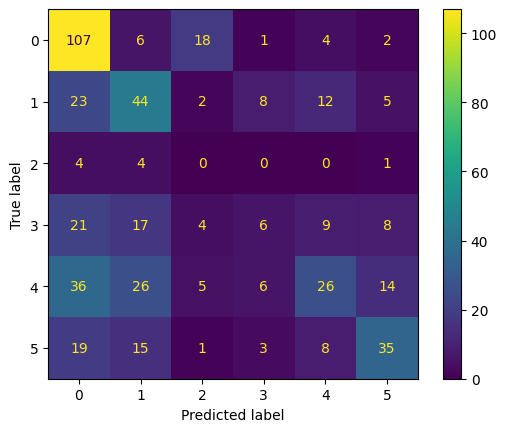

In [38]:
model1_25.show_cm(y_test_main)

### Hidden State = 100

Building model with hidden_state = 100: 

In [39]:
num_classes = 6
hidden_state = 100

model1_100 = Model1()
model1_100.build(input_dim = vocab_size, 
            num_classes = num_classes, 
            embedding_dim = embedding_dim,
            embedding_matrix = embedding_matrix, 
            max_len_train = max_len_train, 
            hidden_state = hidden_state, 
            activation_func = 'softmax', 
            learn_rate = 0.0000001)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 300)           2700000   
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 2,861,006
Trainable params: 161,006
Non-trainable params: 2,700,000
_________________________________________________________________


In [40]:
model1_100.train(train_padded, y_train_main, 0.2, 100, 128)

Fitting
Epoch 1/100
35/35 [==============================] - 5s 85ms/step - loss: 1.6861 - accuracy: 0.2355 - val_loss: 1.6473 - val_accuracy: 0.2566
Epoch 2/100
35/35 [==============================] - 2s 70ms/step - loss: 1.6050 - accuracy: 0.2967 - val_loss: 1.5114 - val_accuracy: 0.3740
Epoch 3/100
35/35 [==============================] - 3s 72ms/step - loss: 1.3745 - accuracy: 0.4256 - val_loss: 1.3929 - val_accuracy: 0.3941
Epoch 4/100
35/35 [==============================] - 3s 73ms/step - loss: 1.2297 - accuracy: 0.5049 - val_loss: 1.1328 - val_accuracy: 0.5417
Epoch 5/100
35/35 [==============================] - 2s 67ms/step - loss: 1.0205 - accuracy: 0.5955 - val_loss: 1.0062 - val_accuracy: 0.6059
Epoch 6/100
35/35 [==============================] - 2s 67ms/step - loss: 0.9031 - accuracy: 0.6595 - val_loss: 0.9840 - val_accuracy: 0.6526
Epoch 7/100
35/35 [==============================] - 2s 68ms/step - loss: 0.8003 - accuracy: 0.7056 - val_loss: 1.2097 - val_accuracy: 0.584

Ploting accuracy of model on training data:

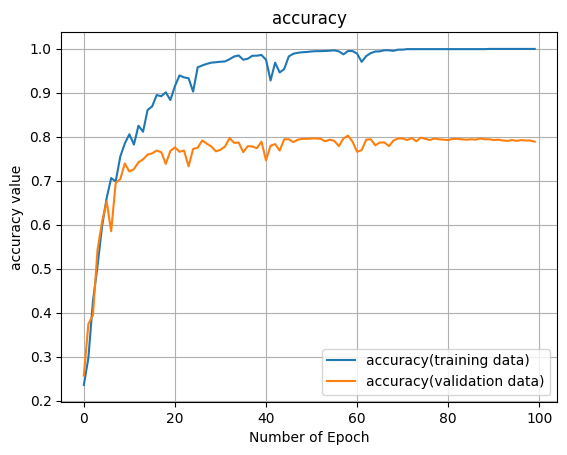

In [41]:
model1_100.plot_result('accuracy')

Ploting loss of model on training data:

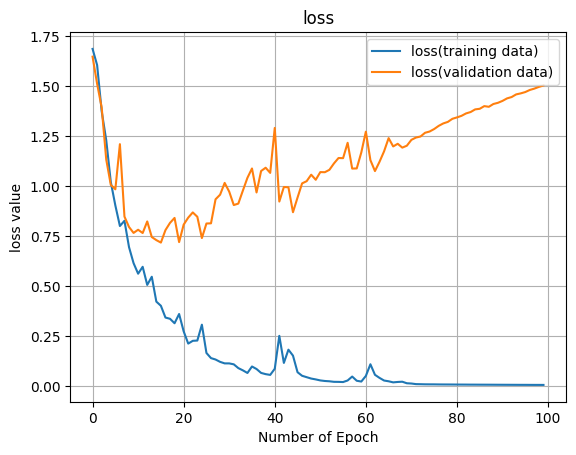

In [42]:
model1_100.plot_result('loss')

Predicting:

In [43]:
model1_100.predict(test_padded)

16/16 [==============================] - 1s 17ms/step


Reporting results:

In [44]:
model1_100.report(y_test_main)

              precision    recall  f1-score   support

           0       0.52      0.82      0.63       138
           1       0.42      0.43      0.42        94
           2       0.06      0.11      0.08         9
           3       0.23      0.14      0.17        65
           4       0.53      0.22      0.31       113
           5       0.49      0.49      0.49        81

    accuracy                           0.46       500
   macro avg       0.37      0.37      0.35       500
weighted avg       0.45      0.46      0.43       500



Confusion matrix:

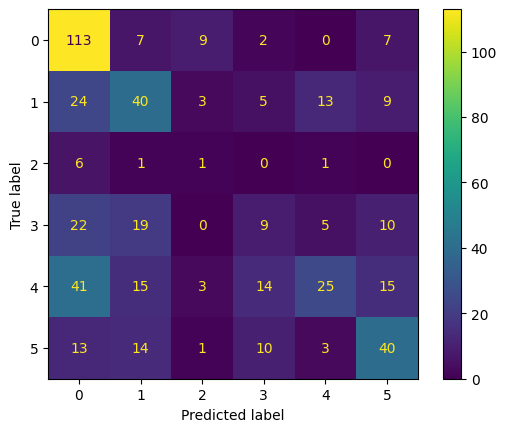

In [45]:
model1_100.show_cm(y_test_main)

## Model 2

In [46]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

class CustomModel(Model):
    def __init__(self, vocab_size, embedding_matrix, seq_length_train, embedding_size=300, lstm_units=64, num_main_classes=6, num_sub_classes=47):
        super(CustomModel, self).__init__()

        self.embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix])
        self.lstm_layer = LSTM(lstm_units, return_sequences=True)
        self.extract_timesteps = Lambda(self._extract_timesteps)
        self.main_output_layer = Dense(num_main_classes, activation='softmax')
        self.sub_output_layer = Dense(num_sub_classes, activation='softmax')

    def call(self, inputs):
        embedding = self.embedding_layer(inputs)
        lstm = self.lstm_layer(embedding)
        second_last, last = self.extract_timesteps(lstm)
        main_output = self.main_output_layer(second_last)
        sub_output = self.sub_output_layer(last)
        return [main_output, sub_output]

    def _extract_timesteps(self, x):
        second_last = x[:, -2, :]
        last = x[:, -1, :]
        return [second_last, last]


    # def fit_model(self, ):

        
seq_length_train = max_len_train
# vocab_size 
# embedding_matrix
# opt

input_layer = Input(shape=(seq_length_train,), dtype='int32')
custom_model = CustomModel(vocab_size, embedding_matrix, seq_length_train)
outputs = custom_model(input_layer)

model_2 = Model(inputs=input_layer, outputs=outputs)
model_2.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 custom_model (CustomModel)  [(None, 6),               2796885   
                              (None, 47)]                        
                                                                 
Total params: 2,796,885
Trainable params: 2,796,885
Non-trainable params: 0
_________________________________________________________________


In [47]:
y_train_fine = np.array([train_data.iloc[i]['label-fine'] for i in range(len(train_data))])
y_train_fine = to_categorical(y_train_fine.squeeze())

# print(len(y_train_fine), len(y_train_main))
# print(len(y_train_fine[0]), len(y_train_main[0]))

history_2 = model_2.fit(train_padded, [y_train_main, y_train_fine], batch_size = 128, epochs=50, validation_split = 0.2)

Epoch 1/50
35/35 [==============================] - 7s 122ms/step - loss: 5.1360 - custom_model_loss: 1.7090 - custom_model_1_loss: 3.4271 - custom_model_accuracy: 0.2277 - custom_model_1_accuracy: 0.1520 - val_loss: 4.7436 - val_custom_model_loss: 1.6505 - val_custom_model_1_loss: 3.0931 - val_custom_model_accuracy: 0.2154 - val_custom_model_1_accuracy: 0.1201
Epoch 2/50
35/35 [==============================] - 4s 112ms/step - loss: 4.7278 - custom_model_loss: 1.6580 - custom_model_1_loss: 3.0698 - custom_model_accuracy: 0.2348 - custom_model_1_accuracy: 0.1715 - val_loss: 4.7098 - val_custom_model_loss: 1.6548 - val_custom_model_1_loss: 3.0550 - val_custom_model_accuracy: 0.2136 - val_custom_model_1_accuracy: 0.1842
Epoch 3/50
35/35 [==============================] - 4s 110ms/step - loss: 4.7130 - custom_model_loss: 1.6556 - custom_model_1_loss: 3.0574 - custom_model_accuracy: 0.2284 - custom_model_1_accuracy: 0.1738 - val_loss: 4.7036 - val_custom_model_loss: 1.6509 - val_custom_mod

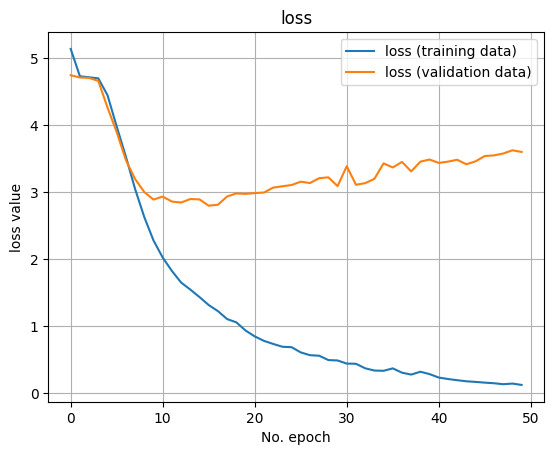

In [48]:
plt.plot(history_2.history['loss'], label='loss (training data)')
plt.plot(history_2.history['val_loss'], label='loss (validation data)')
plt.title('loss')
plt.ylabel('loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.grid()
plt.show()

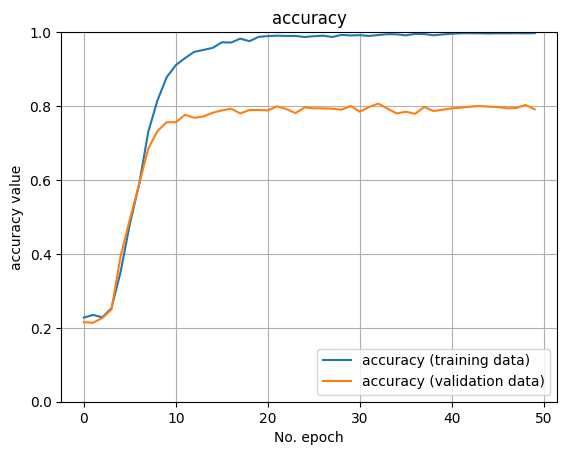

In [53]:
plt.plot(history_2.history['custom_model_accuracy'], label='accuracy (training data)')
plt.plot(history_2.history['val_custom_model_accuracy'], label='accuracy (validation data)')
plt.title('accuracy')
plt.ylabel('accuracy value')
plt.xlabel('No. epoch')
plt.ylim([0,1])
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [54]:
y_test_fine = np.array([test_data.iloc[i]['label-fine'] for i in range(len(test_data))])
y_test_fine = to_categorical(y_test_fine.squeeze())

evaluation = model_2.evaluate(test_padded, [y_test_main, y_test_fine])

main_loss, sub_loss = evaluation[0], evaluation[1]
main_accuracy, sub_accuracy = evaluation[2], evaluation[3]

print(f"Main Loss: {main_loss:.4f}")
print(f"Sub Loss: {sub_loss:.4f}")
print(f"Main Accuracy: {main_accuracy:.4f}")
print(f"Sub Accuracy: {sub_accuracy:.4f}")

16/16 [==============================] - 0s 14ms/step - loss: 9.4620 - custom_model_loss: 3.9293 - custom_model_1_loss: 5.5327 - custom_model_accuracy: 0.4340 - custom_model_1_accuracy: 0.2580
Main Loss: 9.4620
Sub Loss: 3.9293
Main Accuracy: 5.5327
Sub Accuracy: 0.4340
